<style>
o { color: Orange }
</style>

Let's try to find out if<o> Sentinel-5 </o>satellite data can be used for national level air pollution statistics. Currently the statistics are collected by ground stations and does not cover the whole country. If we could find any sort of correlation between satellite NO2 and ground NO2 measurements, we could use the satellite data for environmental monitoring purposes.

H0 -- there is significant correlation between <o>Tropospheric NO2</o> concentration and Ground stations NO2 measurements


# Sentinel 5 and Ground stations NO2 measurement comparison
## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
from math import radians, cos, sin, asin, sqrt
from sklearn.covariance import EllipticEnvelope
from numpy import quantile, where
import matplotlib.pyplot as plt
import seaborn as sns

<style>
o { color: Orange }
</style>
## Import data  
First, I will import <o> Sentinel-5 (s5)</o> and <o> Environmental Protection Agency data (AAA) </o>that I've parsed in previous notebooks 

In [2]:
# sentinel 5 data processed in previous notebook
s5_no2 = pd.read_csv('no2_LT_1001_0228.csv')
s5_no2['time'] = [datetime.datetime.strptime(str(s5_no2.time[i]), '%Y%m%d').strftime('%Y-%m-%d') for i in range(len(s5_no2))]
s5_no2.tail()

,Unnamed: 0,lon,lat,time,no2_tropo,no2_prec,air_mass_f,savivaldybes_pav
335701,335701,21.958338,56.375099,2023-02-28,-4.532503e-06,0.000009,1.704889,Skuodo rajono savivaldybė
335702,335702,22.033825,56.400047,2023-02-28,-1.173571e-05,0.000013,1.672966,Mažeikių rajono savivaldybė
335703,335703,22.108910,56.424740,2023-02-28,-7.355617e-06,0.000010,1.537642,Mažeikių rajono savivaldybė
335704,335704,21.535057,56.291843,2023-02-28,8.021124e-07,0.000014,1.105168,Skuodo rajono savivaldybė
335705,335705,21.612743,56.318161,2023-02-28,-7.302476e-06,0.000011,1.335888,Skuodo rajono savivaldybė


In [3]:
# processed Environmental Protection Agency data
AAA_no2 = pd.read_csv('no2_LT_AAA.csv')
AAA_no2 = AAA_no2.rename(columns = {'name':'sav_name', 'index':'name'})
# we will also take coordinates to find the nearest s5 satelite points
aa_cords = pd.DataFrame(AAA_no2.groupby('name').mean()[['lat','lon']].reset_index()[['name','lat','lon']])
spots = AAA_no2['name'].unique().tolist()
AAA_no2.tail()

C:\Users\KOSTAS~1\AppData\Local\Temp/ipykernel_14604/3089382512.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aa_cords = pd.DataFrame(AAA_no2.groupby('name').mean()[['lat','lon']].reset_index()[['name','lat','lon']])


,Unnamed: 0,name,time,dailyNO2,lat,lon,sav_name,geometry
2260,2260,Jonava,2023-31-01,10.386667,55.072194,24.284829,Jonavos rajono savivaldybė,"POLYGON ((24.2732715 54.9521515, 24.3190205 54..."
2261,2261,Kėdainiai,2023-31-01,7.136667,55.280014,23.957866,Kėdainių rajono savivaldybė,"POLYGON ((23.810094 55.1582865, 23.8101781 55...."
2262,2262,"Kaunas, Noreikiškės",2023-31-01,8.606667,54.883559,23.835927,Kauno rajono savivaldybė,"POLYGON ((23.8632203 55.185257, 23.8630986 55...."
2263,2263,Dzūkija,2023-31-01,0.960000,54.093744,24.287666,Varėnos rajono savivaldybė,"POLYGON ((24.9115304 54.4097995, 24.9073732 54..."
2264,2264,Žemaitija,2023-31-01,1.783333,56.008342,21.886903,Plungės rajono savivaldybė,"POLYGON ((21.6516888 56.0190774, 21.6433397 56..."


<style>
o { color: Orange }
</style>
## Data cleaning and outlier detection
Since s5 is scattered around and AAA data has stationary coordinates, I will filter the closest s5 points to the AAA data using <o>Harvesine distance</o>
### Nearest points
First we will define functions that returns the nearest point distance and returns the name of the nearest point

In [4]:
# finding nearest points https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
def dist(lat1, long1, lat2, long2):
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [5]:
def find_nearest(lat, long):
    distances = aa_cords.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return aa_cords.loc[distances.idxmin(), 'name']

In [7]:
# iterate through s5 data and find the nearest points and calculate distance
s5_no2['name'] = s5_no2.apply(
    lambda row: find_nearest(row['lat'], row['lon']), 
    axis=1)
s5_no2 = pd.merge(s5_no2, aa_cords[['name','lat','lon']],on='name', how='left')
# as both the columns has same name python gets confused 
s5_no2=s5_no2.rename(columns = {'lat_x':'s5_lat','lon_x':'s5_lon','lat_y':'aa_lat','lon_y':'aa_lon'})
s5_no2.tail(5)

,Unnamed: 0,s5_lon,s5_lat,time,no2_tropo,no2_prec,air_mass_f,savivaldybes_pav,index,name,aa_lat,aa_lon
335701,335701,21.958338,56.375099,2023-02-28,-4.532503e-06,0.000009,1.704889,Skuodo rajono savivaldybė,Mažeikiai,Mažeikiai,56.309620,22.331407
335702,335702,22.033825,56.400047,2023-02-28,-1.173571e-05,0.000013,1.672966,Mažeikių rajono savivaldybė,Mažeikiai,Mažeikiai,56.309620,22.331407
335703,335703,22.108910,56.424740,2023-02-28,-7.355617e-06,0.000010,1.537642,Mažeikių rajono savivaldybė,Mažeikiai,Mažeikiai,56.309620,22.331407
335704,335704,21.535057,56.291843,2023-02-28,8.021124e-07,0.000014,1.105168,Skuodo rajono savivaldybė,Žemaitija,Žemaitija,56.008342,21.886903
335705,335705,21.612743,56.318161,2023-02-28,-7.302476e-06,0.000011,1.335888,Skuodo rajono savivaldybė,Žemaitija,Žemaitija,56.008342,21.886903


### Distance
now let's return the distance column

In [8]:
# now the distance
s5_no2['distance'] = [dist(s5_no2.s5_lat[i], s5_no2.s5_lon[i],s5_no2.aa_lat[i] ,s5_no2.aa_lon[i]) for i in range(len(s5_no2))]
s5_no2['distance'] = s5_no2['distance'].round(decimals=3)
# since s5 resolution is 7x7, we will keep only the measurements that are in the area
s5_no2 = pd.DataFrame(s5_no2[s5_no2.distance < 7][['time','name','no2_tropo']].groupby(['time','name']).mean().reset_index())
# Printing the data table 
s5_no2.tail(5)

,time,name,no2_tropo
2061,2023-02-28,"Vilnius, Savanorių pr.",-0.000007
2062,2023-02-28,"Vilnius, Senamiestis",-0.000012
2063,2023-02-28,"Vilnius, Žirmūnai",-0.000006
2064,2023-02-28,Šiauliai,-0.000017
2065,2023-02-28,Žemaitija,-0.000006


In [9]:
# Join two dataframes together to get the measurement data (no2 by AAA)
AAA_no2 = AAA_no2[['name','time','dailyNO2']].groupby(['time','name']).mean().reset_index()
s5_no2 = s5_no2.merge(AAA_no2,
            left_on=['time','name'], 
            right_on=['time','name'], 
            how='left')
# clean from missing values
s5_no2 = s5_no2[~s5_no2.dailyNO2.isna()]
s5_no2.tail()

,time,name,no2_tropo,dailyNO2
1840,2023-02-12,"Vilnius, Savanorių pr.",0.000047,6.500000
1841,2023-02-12,"Vilnius, Senamiestis",0.000062,5.930000
1842,2023-02-12,"Vilnius, Žirmūnai",0.000060,16.890000
1843,2023-02-12,Šiauliai,0.000012,16.186667
1844,2023-02-12,Žemaitija,0.000006,1.150000


<style>
o { color: Orange }
</style>
### Outlier detection  
Let's get rid of the outliers from s5 and AAA measurements using <o>Eliptic envelope algorithm </o> 

In [10]:
# set the column that you want to clean from outliers
def bye_bye_outliers(df, col, multiplication_factor=None):
    """Give Col name as String and the outliers will be removed using eliptic envelope algorithm"""
    # since the values are too small, we introduce the multiplication constant
    if multiplication_factor != None:
        bb = np.array(df[col]*multiplication_factor).reshape(-1, 1)
        elenv = EllipticEnvelope(contamination=.02)
        pred = elenv.fit_predict(bb)
        anom_index=where(pred == -1)
    else:
        bb = np.array(df[col]).reshape(-1, 1)
        elenv = EllipticEnvelope(contamination=.02)
        pred = elenv.fit_predict(bb)
        anom_index=where(pred == -1)
    # values = bb[anom_index]
    return anom_index

In [11]:
# clean the AAA NO2 data from outliers
anom_index = bye_bye_outliers(s5_no2, 'dailyNO2', None)
s5_no2 = s5_no2[~s5_no2.index.isin(anom_index)].reset_index(drop=True)
s5_no2 = s5_no2[~s5_no2.no2_tropo.isna()]

In [12]:
# now do the same and clean the S5 NO2 data from outliers
anom_index2 = bye_bye_outliers(s5_no2, 'no2_tropo', 100000)
s5_no2 = s5_no2[~s5_no2.index.isin(anom_index2)].reset_index(drop=True)
s5_no2.tail()

,time,name,no2_tropo,dailyNO2
762,2023-02-12,"Vilnius, Savanorių pr.",0.000047,6.500000
763,2023-02-12,"Vilnius, Senamiestis",0.000062,5.930000
764,2023-02-12,"Vilnius, Žirmūnai",0.000060,16.890000
765,2023-02-12,Šiauliai,0.000012,16.186667
766,2023-02-12,Žemaitija,0.000006,1.150000


## Calculations
Let's try to calculate the correlation between the two variables. Jumping one step further, I will first create Lagged variables for our measurements so we could see if particles that previously were in atmosphere are now concentrated towards ground and vice versa.
### Introducing Lag 

In [13]:
# set index
s5_no2 = s5_no2[['name','time','dailyNO2', 'no2_tropo']].groupby(['time','name']).mean()
# introducing Lags
for i in range(1,8):
    s5_no2['dailyNO2_lag_'+str(i)] = s5_no2.groupby(level=1).dailyNO2.shift(-i)
    s5_no2['no2_tropo_lag_'+str(i)] = s5_no2.groupby(level=1).no2_tropo.shift(-i)

In [14]:
s5_no2.head()

dailyNO2  no2_tropo  dailyNO2_lag_1  \
time       name                                                        
2022-10-03 Dzūkija               0.380000   0.000012        0.633333   
           Jonava                6.243333   0.000032        4.333333   
           Kaunas, Noreikiškės  15.360000   0.000017        6.946667   
           Kaunas, Petrašiūnai  22.750000   0.000028       19.823333   
           Klaipėda, Centras    16.633333   0.000035        5.353333   

                                no2_tropo_lag_1  dailyNO2_lag_2  \
time       name                                                   
2022-10-03 Dzūkija                     0.000116        0.636667   
           Jonava                      0.000079       12.746667   
           Kaunas, Noreikiškės         0.000057        8.923333   
           Kaunas, Petrašiūnai         0.000058       42.956667   
           Klaipėda, Centras           0.000042       14.853333   

                                no2_tropo_lag_2  dailyNO2_lag_3  \
time       name                                                   
2022-10-03 Dzūkija                     0.000043        4.656667   
           Jonava                      0.000035       13.576667   
           Kaunas, Noreikiškės         0.000035       12.746667   
           Kaunas, Petrašiūnai         0.000034       67.493333   
           Klaipėda, Centras           0.000027       14.146667   

                                no2_tropo_lag_3  dailyNO2_lag_4  \
time       name                                                   
2022-10-03 Dzūkija                     0.000042        1.403333   
           Jonava                      0.000024       20.903333   
           Kaunas, Noreikiškės         0.000024       11.280000   
           Kaunas, Petrašiūnai         0.000036       53.470000   
           Klaipėda, Centras           0.000013       11.663333   

                                no2_tropo_lag_4  dailyNO2_lag_5  \
time       name                                                   
2022-10-03 Dzūkija                     0.000107        2.486667   
           Jonava                      0.000125        8.030000   
           Kaunas, Noreikiškės         0.000146        8.986667   
           Kaunas, Petrašiūnai         0.000137       17.016667   
           Klaipėda, Centras           0.000223       23.070000   

                                no2_tropo_lag_5  dailyNO2_lag_6  \
time       name                                                   
2022-10-03 Dzūkija                     0.000054        2.550000   
           Jonava                      0.000063        2.103333   
           Kaunas, Noreikiškės         0.000055        5.033333   
           Kaunas, Petrašiūnai         0.000052        8.413333   
           Klaipėda, Centras           0.000034       15.680000   

                                no2_tropo_lag_6  dailyNO2_lag_7  \
time       name                                                   
2022-10-03 Dzūkija                     0.000084        1.593333   
           Jonava                      0.000028       11.216667   
           Kaunas, Noreikiškės         0.000014       22.940000   
           Kaunas, Petrašiūnai         0.000035       39.133333   
           Klaipėda, Centras           0.000050       33.080000   

                                no2_tropo_lag_7  
time       name                                  
2022-10-03 Dzūkija                     0.000063  
           Jonava                      0.000037  
           Kaunas, Noreikiškės         0.000061  
           Kaunas, Petrašiūnai         0.000047  
           Klaipėda, Centras           0.000039

In [15]:
# creating a new df that will reflect the percentage change
df = s5_no2.copy()
df.sort_index(inplace=True)
df = df.pct_change()
df = df[~df.isna()]
# Obtain correlation matrix. Round the values to 2 decimal cases.
corr = np.round(df.corr(method="spearman"), decimals=2)
df.head()

dailyNO2  no2_tropo  dailyNO2_lag_1  \
time       name                                                        
2022-10-03 Dzūkija                    NaN        NaN             NaN   
           Jonava               15.429825   1.713969        5.842105   
           Kaunas, Noreikiškės   1.460224  -0.459085        0.603077   
           Kaunas, Petrašiūnai   0.481120   0.586813        1.853647   
           Klaipėda, Centras    -0.268864   0.276923       -0.729948   

                                no2_tropo_lag_1  dailyNO2_lag_2  \
time       name                                                   
2022-10-03 Dzūkija                          NaN             NaN   
           Jonava                     -0.317319       19.020942   
           Kaunas, Noreikiškės        -0.278009       -0.299948   
           Kaunas, Petrašiūnai         0.013044        3.813971   
           Klaipėda, Centras          -0.282356       -0.654225   

                                no2_tropo_lag_2  dailyNO2_lag_3  \
time       name                                                   
2022-10-03 Dzūkija                          NaN             NaN   
           Jonava                     -0.184478        1.915533   
           Kaunas, Noreikiškės        -0.016199       -0.061134   
           Kaunas, Petrašiūnai        -0.029804        4.294979   
           Klaipėda, Centras          -0.197203       -0.790399   

                                no2_tropo_lag_3  dailyNO2_lag_4  \
time       name                                                   
2022-10-03 Dzūkija                          NaN             NaN   
           Jonava                     -0.427716       13.895487   
           Kaunas, Noreikiškės        -0.017526       -0.460373   
           Kaunas, Petrašiūnai         0.506337        3.740248   
           Klaipėda, Centras          -0.641855       -0.781871   

                                no2_tropo_lag_4  dailyNO2_lag_5  \
time       name                                                   
2022-10-03 Dzūkija                          NaN             NaN   
           Jonava                      0.167887        2.229223   
           Kaunas, Noreikiškės         0.168858        0.119137   
           Kaunas, Petrašiūnai        -0.064063        0.893546   
           Klaipėda, Centras           0.632808        0.355730   

                                no2_tropo_lag_5  dailyNO2_lag_6  \
time       name                                                   
2022-10-03 Dzūkija                          NaN             NaN   
           Jonava                      0.164996       -0.175163   
           Kaunas, Noreikiškės        -0.119149        1.393027   
           Kaunas, Petrašiūnai        -0.065398        0.671523   
           Klaipėda, Centras          -0.353661        0.863708   

                                no2_tropo_lag_6  dailyNO2_lag_7  \
time       name                                                   
2022-10-03 Dzūkija                          NaN             NaN   
           Jonava                     -0.664282        6.039749   
           Kaunas, Noreikiškės        -0.521444        1.045171   
           Kaunas, Petrašiūnai         1.590346        0.705899   
           Klaipėda, Centras           0.439257       -0.154685   

                                no2_tropo_lag_7  
time       name                                  
2022-10-03 Dzūkija                          NaN  
           Jonava                     -0.402516  
           Kaunas, Noreikiškės         0.641072  
           Kaunas, Petrašiūnai        -0.234038  
           Klaipėda, Centras          -0.179112

## Visualisations
### Correlation Heatmap

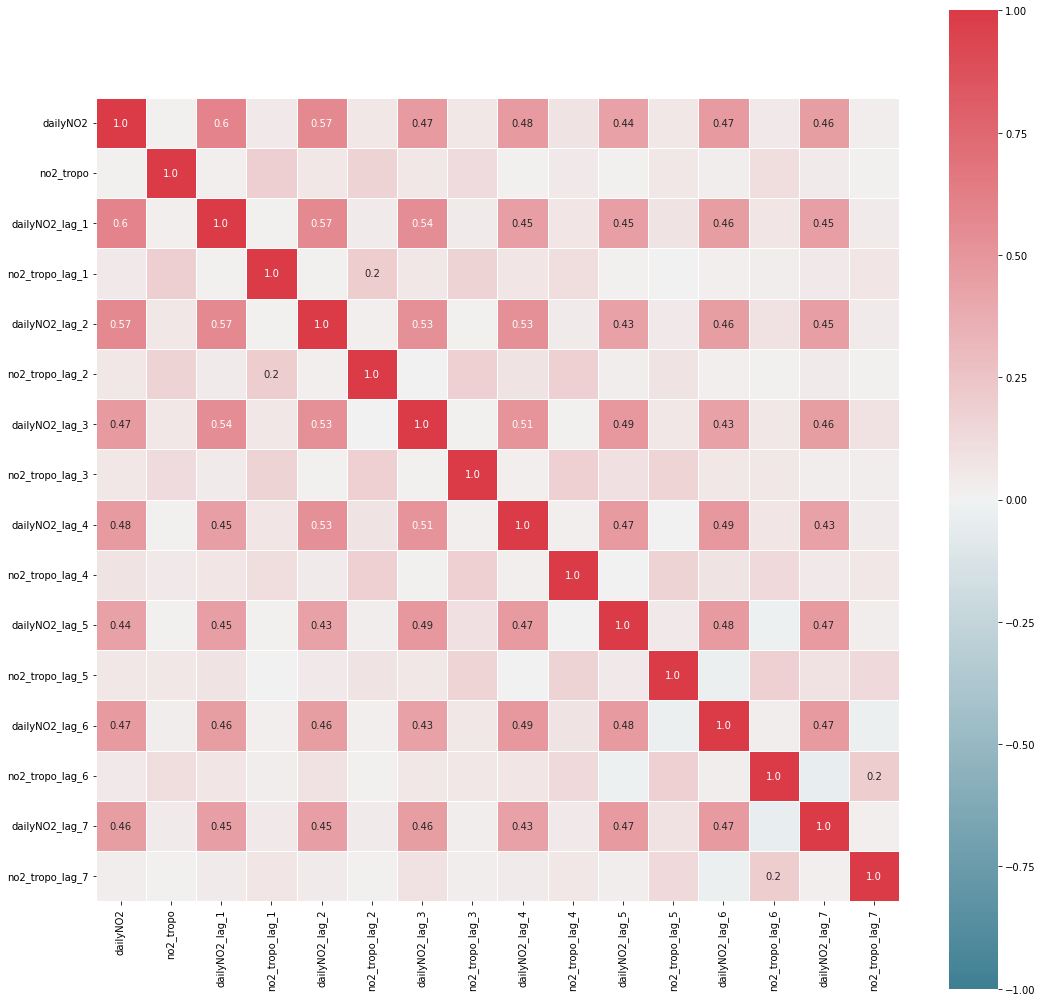

In [16]:
fig = plt.figure(figsize=(18, 18))
# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.2
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

#### Lineplot : Town check
let's plot lineplots for each town and do some visual inspection


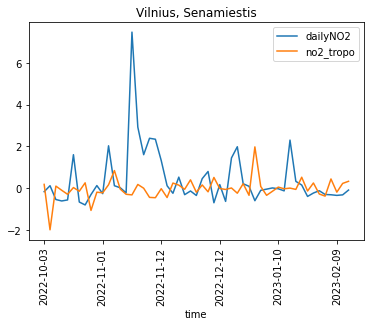

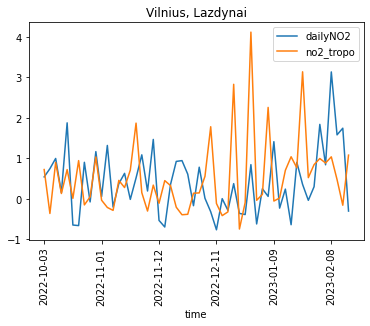

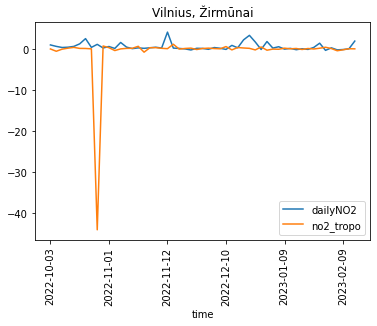

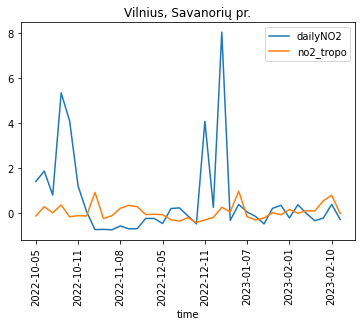

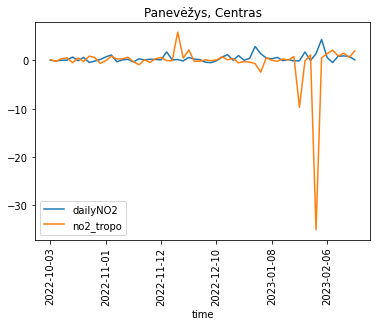

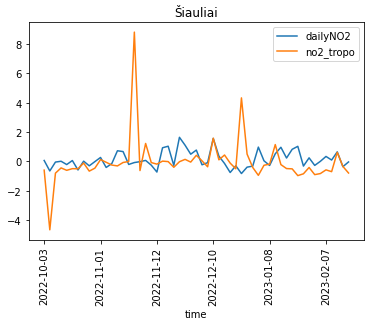

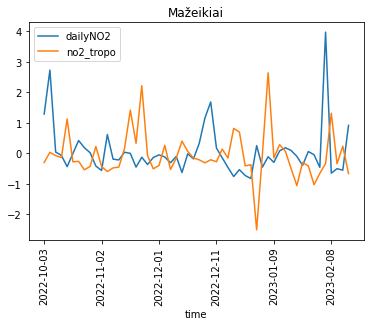

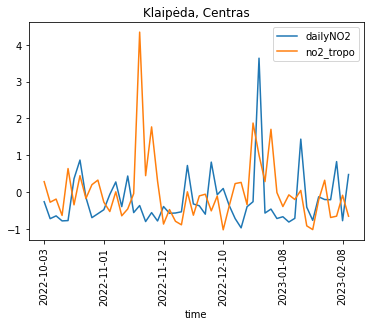

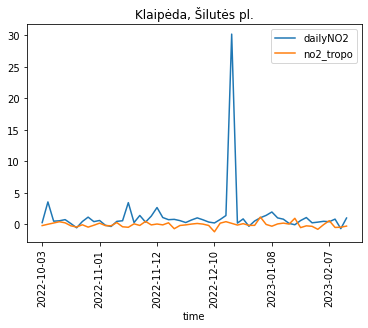

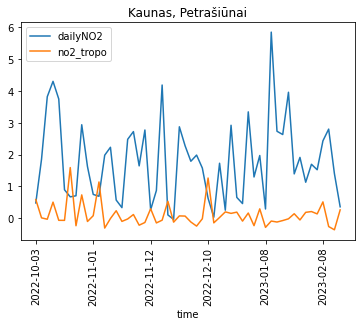

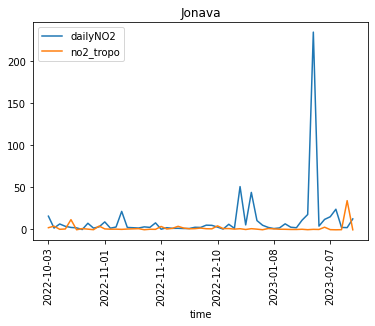

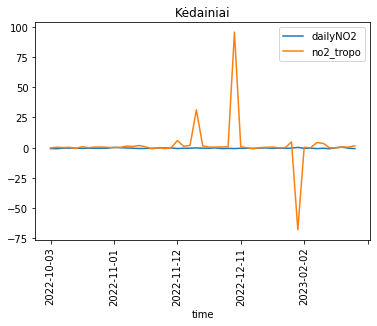

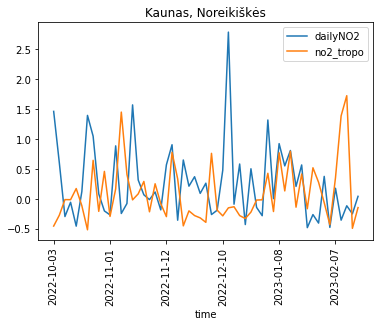

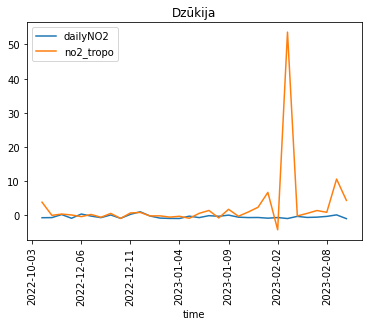

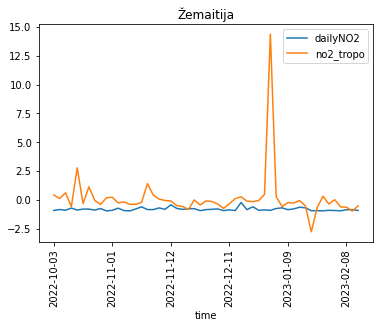

In [17]:
tst = df.reset_index().copy()
for i in range(len(spots)):
    tmp = tst[tst['name'] == spots[i]]
    tmp = tmp.drop('name', axis=1).set_index('time')
    tmp[['dailyNO2','no2_tropo']].plot.line(rot=90, title=spots[i])

## Final Check

Since the results were not promissing, last hope is that some single point reflection could give us any better correlation. Let's findout where the correlation coefficient is the highest.

In [18]:
# spots
tst = df.reset_index().copy()
for i in range(len(spots)): # dzukija etc
    tmp = tst[tst['name'] == spots[i]]
    x = pd.Series(tmp.dailyNO2)
    y = pd.Series(tmp.no2_tropo)
    print(spots[i] , 'Pearson corr: dailyNO2 -> no2_tropo_lag_1', x.corr(y) )                    # Pearson's r
    print(spots[i] , 'Pearson corr: no2_tropo_lag_1 -> dailyNO2', y.corr(x))
    print(spots[i] , 'Spearman rho corr: ', x.corr(y, method='spearman')) 

Vilnius, Senamiestis Pearson corr: dailyNO2 -> no2_tropo_lag_1 -0.13667233007040575
Vilnius, Senamiestis Pearson corr: no2_tropo_lag_1 -> dailyNO2 -0.13667233007040575
Vilnius, Senamiestis Spearman rho corr:  -0.12425415255603935
Vilnius, Lazdynai Pearson corr: dailyNO2 -> no2_tropo_lag_1 0.10008086834679783
Vilnius, Lazdynai Pearson corr: no2_tropo_lag_1 -> dailyNO2 0.10008086834679784
Vilnius, Lazdynai Spearman rho corr:  0.12010672765389745
Vilnius, Žirmūnai Pearson corr: dailyNO2 -> no2_tropo_lag_1 -0.08601756507675022
Vilnius, Žirmūnai Pearson corr: no2_tropo_lag_1 -> dailyNO2 -0.08601756507675021
Vilnius, Žirmūnai Spearman rho corr:  -0.14021931946460248
Vilnius, Savanorių pr. Pearson corr: dailyNO2 -> no2_tropo_lag_1 0.0445273837525702
Vilnius, Savanorių pr. Pearson corr: no2_tropo_lag_1 -> dailyNO2 0.0445273837525702
Vilnius, Savanorių pr. Spearman rho corr:  0.003793266951161688
Panevėžys, Centras Pearson corr: dailyNO2 -> no2_tropo_lag_1 -0.15870314501037863
Panevėžys, Centra

Ok, so Mažeikiai seems to have a relitively high value(not really, but taking it as last resort), so I will check if there is absolutely nothing to grab on

#### Correlation Heatmap for mazeikiai

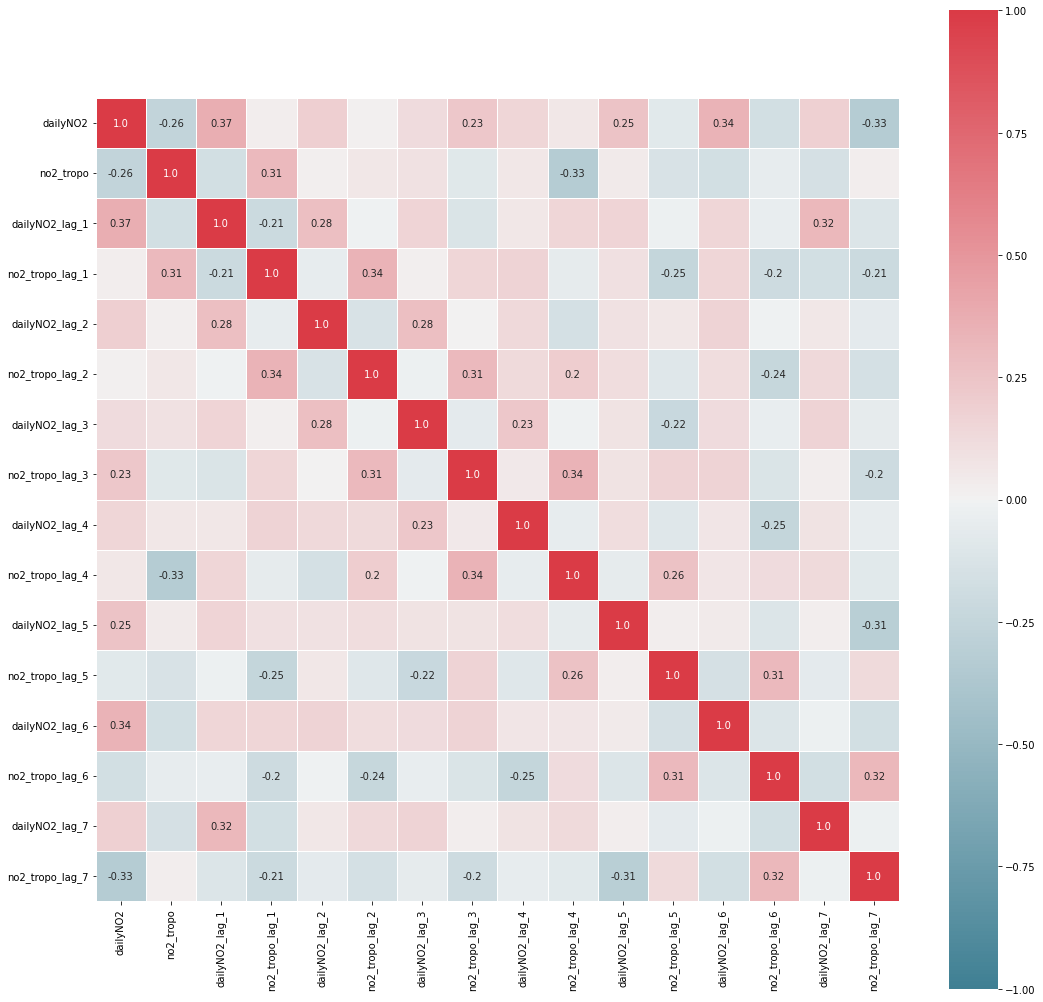

In [19]:
mazeikia = df.reset_index()
mazeikia = mazeikia[mazeikia['name'] == 'Mažeikiai'].drop(['time','name'], axis=1)
fig = plt.figure(figsize=(18, 18))
corr = np.round(mazeikia.corr(method="spearman"), decimals=2)
# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.2
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

<style>
o { color: Orange }
r { color: Red}
</style>
Unofortunately, there is no correlation between <r>Sentinel 5 NO2</r> data and <r> Environmental Protection Agency </r> data, therefore <o>H0 has to be rejected</o>